In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
from PIL import Image

In [4]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
from torchvision import transforms, utils, models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [5]:
from synthetic_utils import *

In [22]:
from trainer_dataloader import *
from networks import *
from losses import *

In [7]:
class ShapesDataset(Dataset):
    '''Shapes dataset'''

    def __init__(self, txt_file, root_dir, transform=None):
        """
        Args:
            txt_file (string): Path to the txt file with annotations
            root_dit (string): Directory with all the images
            crop_face (bool): To decide to get the cropped face or full image
            transform (callable, optional): optional transform on a sample
        """
        self.shapes_frame = pd.read_csv(txt_file, delimiter='\t', header=None, names=['id', 'shape_type', 'color'])
        self.root_dir = root_dir
        self.transform = transform
        self.shapes = self.shapes_frame.shape_type.unique()
        self.colors = self.shapes_frame.color.unique()
#         self.shapes_frame["shape_type"] = self.shapes_frame['shape_type'].map({ "circle": 0, "rectangle": 1 })
#         self.shapes_frame["color"] = self.shapes_frame['color'].map({ "red": 0, "green": 1 })
        ind = [0, 1]
        self.shape_to_num = dict(zip(self.shapes, ind))
        self.color_to_num = dict(zip(self.colors, ind))

    def __len__(self):
        return len(self.shapes_frame)

    def __getitem__(self, idx):
        self.shape_type = self.shapes_frame.iloc[idx]['shape_type']
        self.color = self.shapes_frame.iloc[idx]['color']
        self.id = self.shapes_frame.iloc[idx]['id']

        img_path = os.path.join(self.root_dir, self.shape_type, '{}_{}.png'.format(self.id, self.color))
        img = Image.open(img_path)
        
        labels = {'shape_type': self.shape_to_num[self.shape_type], 'color': self.color_to_num[self.color]}

        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)

        return img, labels

In [8]:
if torch.cuda.is_available():
    device="cuda"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device="cpu"
    torch.set_default_tensor_type('torch.FloatTensor')
print(device)

cuda


In [9]:
DATA_PATH = '/home/s1791387/gen_new/'
TXT_PATH = os.path.join(DATA_PATH, 'dataset.txt')

In [10]:
input_size = 96

In [11]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
        ])
    }

In [12]:
df = ShapesDataset(TXT_PATH, DATA_PATH, transform=data_transforms['train'])

In [13]:
len(df)

5000

In [14]:
toPIL = transforms.ToPILImage()

{'shape_type': 1, 'color': 0}

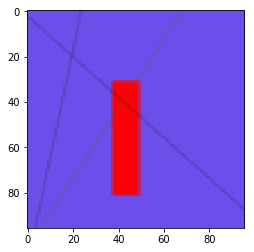

In [15]:
img, label = df[5]
plt.imshow(toPIL(img))
label

{'shape_type': 0, 'color': 1}

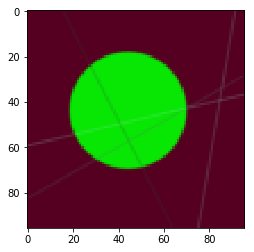

In [16]:
img, label = df[1]
plt.imshow(toPIL(img))
label

In [17]:
valid_size = 0.15

In [18]:
indices = list(range(len(df)))
split = int(np.floor(valid_size * len(df)))
np.random.seed(1791387)
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [19]:
train_loader = torch.utils.data.DataLoader(
        df, batch_size=64, sampler=train_sampler,
        num_workers=4, pin_memory=True,
    )
valid_loader = torch.utils.data.DataLoader(
        df, batch_size=64, sampler=valid_sampler,
        num_workers=4, pin_memory=True,
    )

In [20]:
len(train_loader), len(valid_loader)

(67, 12)

## Train only encoder first

In [45]:
encoder = LeNet()
classifier = ClassNet()

In [46]:
criterion = nn.BCELoss()
opt_cls = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_enc = optim.Adam(encoder.parameters(), lr=0.001, betas=(0.9, 0.999))

In [48]:
num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
#         scheduler_cls.step()
#         scheduler_enc.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(train_loader, encoder,
                                classifier, opt_enc,
                                opt_cls, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(valid_loader, encoder, classifier, criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/100


/home/s1791387/miniconda3/envs/fairness/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/67]	Time 2.096 (2.096)	Loss 0.4317 (0.4317)	Accuracy 0.7812 (0.7812)
Batch: [20/67]	Time 1.264 (0.558)	Loss 0.5439 (0.5228)	Accuracy 0.7188 (0.7106)
Batch: [40/67]	Time 1.113 (0.526)	Loss 0.4343 (0.5235)	Accuracy 0.7969 (0.7199)
Batch: [60/67]	Time 1.139 (0.504)	Loss 0.4681 (0.5073)	Accuracy 0.7812 (0.7377)
----------


/home/s1791387/miniconda3/envs/fairness/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/12]	Time 4.960 (4.960)	Loss 0.4835 (0.4835)	Accuracy 0.7344 (0.7344)
Avg validation loss: 0.47430115032196046 	 Accuracy: 0.7506666666666667
--------------------
Epoch 0/100	Time 45.513 sec (45.513 sec)
--------------------
Epoch: 1/100


/home/s1791387/miniconda3/envs/fairness/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/67]	Time 2.281 (2.281)	Loss 0.4563 (0.4563)	Accuracy 0.7812 (0.7812)
Batch: [20/67]	Time 1.739 (0.557)	Loss 0.3812 (0.4370)	Accuracy 0.8750 (0.7917)
Batch: [40/67]	Time 1.006 (0.496)	Loss 0.4171 (0.4316)	Accuracy 0.8125 (0.7965)
Batch: [60/67]	Time 0.763 (0.475)	Loss 0.4087 (0.4230)	Accuracy 0.8281 (0.8023)
----------
Test: [0/12]	Time 1.879 (1.879)	Loss 0.3986 (0.3986)	Accuracy 0.7812 (0.7812)
Avg validation loss: 0.40316018788019814 	 Accuracy: 0.8
--------------------
Epoch 1/100	Time 36.287 sec (40.900 sec)
--------------------
Epoch: 2/100
Batch: [0/67]	Time 2.220 (2.220)	Loss 0.3489 (0.3489)	Accuracy 0.8281 (0.8281)
Batch: [20/67]	Time 1.514 (0.524)	Loss 0.3123 (0.3319)	Accuracy 0.8281 (0.8452)
Batch: [40/67]	Time 1.407 (0.480)	Loss 0.3462 (0.3298)	Accuracy 0.8906 (0.8556)
Batch: [60/67]	Time 1.436 (0.466)	Loss 0.3623 (0.3202)	Accuracy 0.8125 (0.8607)
----------
Test: [0/12]	Time 2.081 (2.081)	Loss 0.2752 (0.2752)	Accuracy 0.8594 (0.8594)
Avg validation loss: 0.31451366

Process Process-94:
Process Process-93:
Process Process-96:
Process Process-95:
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/s1791387/miniconda3/envs/fairness/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/s1791387/miniconda3/envs/fairness/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/s1791387/miniconda3/envs/fairness/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/s1791387/miniconda3/envs/fairness/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/s1791387/miniconda3/envs/fairness/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/s1791387/miniconda3/envs/fairness/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/s1791387/miniconda3/envs/fairness/lib/python3.6/multiprocessing/process.py", line 93, in r

In [ ]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)
plt.tight_layout()

In [ ]:
with open('plot_data/eo/onlycls.pkl', 'wb+') as f:
    pickle.dump([train_losses, train_accs, val_losses, val_accs], f)

## Train only adversary

In [ ]:
adv_encoder = LeNet()
adversary = ClassNet()

In [ ]:
adv_criterion = nn.BCELoss()
opt_adv = optim.Adam(adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_adv_enc = optim.Adam(adv_encoder.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
num_epochs = 100
atrain_losses = []
atrain_accs = []
aval_losses = []
aval_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
#         scheduler_cls.step()
#         scheduler_enc.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(train_loader, adv_encoder,
                                adversary, opt_adv_enc, opt_adv, adv_criterion, device)
        atrain_losses.append(train_loss)
        atrain_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(adv_encoder, adversary,
                                imgs_val, colors_val, adv_criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        aval_losses.append(val_loss)
        aval_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('training classification loss')
plt.plot(atrain_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(atrain_accs)
plt.plot(aval_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(aval_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(aval_accs)
plt.tight_layout()

In [ ]:
with open('plot_data/eo/onlyadv.pkl', 'wb') as f:
    pickle.dump([atrain_losses, atrain_accs, aval_losses, aval_accs], f)

## Train adversary on original encoder

In [ ]:
fixenc_adversary = ClassNet()
fixenc_adv_criterion = nn.BCELoss()
fixenc_opt_adv = optim.Adam(fixenc_adversary.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
num_epochs = 100
fatrain_losses = []
fatrain_accs = []
faval_losses = []
faval_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
#         scheduler_cls.step()
#         scheduler_enc.step()
        # train
        
        train_loss, train_acc = train_classifier_epoch(encoder, fixenc_adversary, 
                                                       imgs_train, colors_train, 
                                                       fixenc_opt_adv, fixenc_adv_criterion, 
                                                       device)
        fatrain_losses.append(train_loss)
        fatrain_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(encoder, fixenc_adversary,
                                imgs_val, colors_val, fixenc_adv_criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        faval_losses.append(val_loss)
        faval_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('training classification loss')
plt.plot(fatrain_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(fatrain_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(faval_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(faval_accs)
plt.tight_layout()

In [ ]:
with open('plot_data/eo/fixenc_adv.pkl', 'wb') as f:
    pickle.dump([fatrain_losses, fatrain_accs, faval_losses, faval_accs], f)

## LAFTR Training

In [23]:
laftr_encoder = LeNet()
laftr_adversary = ClassNet()
laftr_classifier = ClassNet()

In [24]:
laftr_adv_criterion = AdvEqOddsLoss()
laftr_cls_criterion = nn.BCELoss()

In [25]:
laftr_opt_adv = optim.Adam(laftr_adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
laftr_opt_cls = optim.Adam(laftr_classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
laftr_opt_enc = optim.Adam(laftr_encoder.parameters(), lr=0.001, betas=(0.9, 0.999))

In [26]:
num_epochs = 50

clsTrain_losses = []
clsTrain_accs = []
clsTrainCombined_losses = []
advTrain_losses = []
advTrain_accs = []
advTrainCombined_losses = []

combinedVal_losses = []
clsVal_losses = []
clsVal_accs = []
advVal_losses = []
advVal_accs = []

epoch_time = AverageMeter()

In [27]:
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        
        cls_loss, cls_en_combinedLoss, cls_en_acc, adv_loss, adv_combinedLoss, adv_acc = laftr_epoch(train_loader,
                                                        laftr_encoder, laftr_classifier, laftr_adversary,
                                                        laftr_opt_enc, laftr_opt_cls, laftr_opt_adv, 
                                                        laftr_cls_criterion, laftr_adv_criterion, device)
        
        clsTrain_losses.append(cls_loss)
        clsTrain_accs.append(cls_en_acc)
        clsTrainCombined_losses.append(cls_en_combinedLoss)
        advTrain_losses.append(adv_loss)
        advTrain_accs.append(adv_acc)
        advTrainCombined_losses.append(adv_combinedLoss)
        
        print('Classifier accuracy: {}\t Adversary Accuracy: {}'.format(cls_en_acc, adv_acc))
        # validate
        print('-'*10)
        
        combinedVal_loss, clsVal_loss, clsVal_acc, advVal_loss, advVal_acc = laftr_validate(valid_loader,
                                                        laftr_encoder, laftr_classifier, laftr_adversary, 
                                                        laftr_cls_criterion, laftr_adv_criterion, device)
        
        combinedVal_losses.append(combinedVal_loss)
        clsVal_losses.append(clsVal_loss)
        clsVal_accs.append(clsVal_acc)
        advVal_losses.append(advVal_loss)
        advVal_accs.append(advVal_acc)
        
        print('Classifier validation acc: {:.4f} \t Adv validation acc: {:.4f}'.format(clsVal_acc, advVal_acc))
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/50


/home/s1791387/miniconda3/envs/fairness/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/67]	Time 2.516 (2.516)
Classifier loss 0.6933 (0.6933)	Adversary loss -0.0149 (-0.0149)
Combined Loss during classifier step 0.6931 (0.6931)	Combined Loss during adversary step -0.6729 (-0.6729)
Classifier Accuracy 0.5000 (0.5000)	Adversary Accuracy 0.5312 (0.5312)
Batch: [20/67]	Time 1.940 (0.705)
Classifier loss 0.7967 (0.7211)	Adversary loss -0.6375 (-0.5157)
Combined Loss during classifier step 0.6760 (0.3652)	Combined Loss during adversary step -0.0090 (-0.1823)
Classifier Accuracy 0.5000 (0.5089)	Adversary Accuracy 0.1719 (0.2284)
Batch: [40/67]	Time 0.629 (0.619)
Classifier loss 0.6746 (0.7079)	Adversary loss -0.0065 (-0.3426)
Combined Loss during classifier step 0.6704 (0.5018)	Combined Loss during adversary step -0.6905 (-0.3467)
Classifier Accuracy 0.5625 (0.5290)	Adversary Accuracy 0.5312 (0.3369)
Batch: [60/67]	Time 1.809 (0.625)
Classifier loss 0.6628 (0.6906)	Adversary loss -0.0368 (-0.2346)
Combined Loss during classifier step 0.6396 (0.5489)	Combined Loss duri

/home/s1791387/miniconda3/envs/fairness/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test batch: [0/12]	Time 3.670 (3.670)
Classifier loss 0.6540 (0.6540)	Adversary loss -0.9474 (-0.9474)
Combined Loss -0.2934 (-0.2934)	Classifier Accuracy 0.5781 (0.5781)	Adversary Accuracy 0.2344 (0.2344)
Classifier validation acc: 0.6160 	 Adv validation acc: 0.2747
--------------------
Epoch 0/50	Time 53.504 sec (53.504 sec)
--------------------
Epoch: 1/50


/home/s1791387/miniconda3/envs/fairness/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/67]	Time 2.170 (2.170)
Classifier loss 0.6291 (0.6291)	Adversary loss -1.2134 (-1.2134)
Combined Loss during classifier step -0.2240 (-0.2240)	Combined Loss during adversary step 0.5698 (0.5698)
Classifier Accuracy 0.5781 (0.5781)	Adversary Accuracy 0.0938 (0.0938)
Batch: [20/67]	Time 1.396 (0.544)
Classifier loss 0.6414 (0.6614)	Adversary loss -1.7709 (-1.6034)
Combined Loss during classifier step -1.1037 (-0.8931)	Combined Loss during adversary step 1.1528 (0.9633)
Classifier Accuracy 0.6875 (0.6689)	Adversary Accuracy 0.0312 (0.0737)
Batch: [40/67]	Time 1.577 (0.505)
Classifier loss 0.5894 (0.6370)	Adversary loss -1.8318 (-1.7124)
Combined Loss during classifier step -1.2364 (-1.0445)	Combined Loss during adversary step 1.2434 (1.0927)
Classifier Accuracy 0.6562 (0.6753)	Adversary Accuracy 0.0312 (0.0534)
Batch: [60/67]	Time 1.144 (0.501)
Classifier loss 0.5645 (0.6075)	Adversary loss -1.8779 (-1.7587)
Combined Loss during classifier step -1.3033 (-1.1256)	Combined Loss du

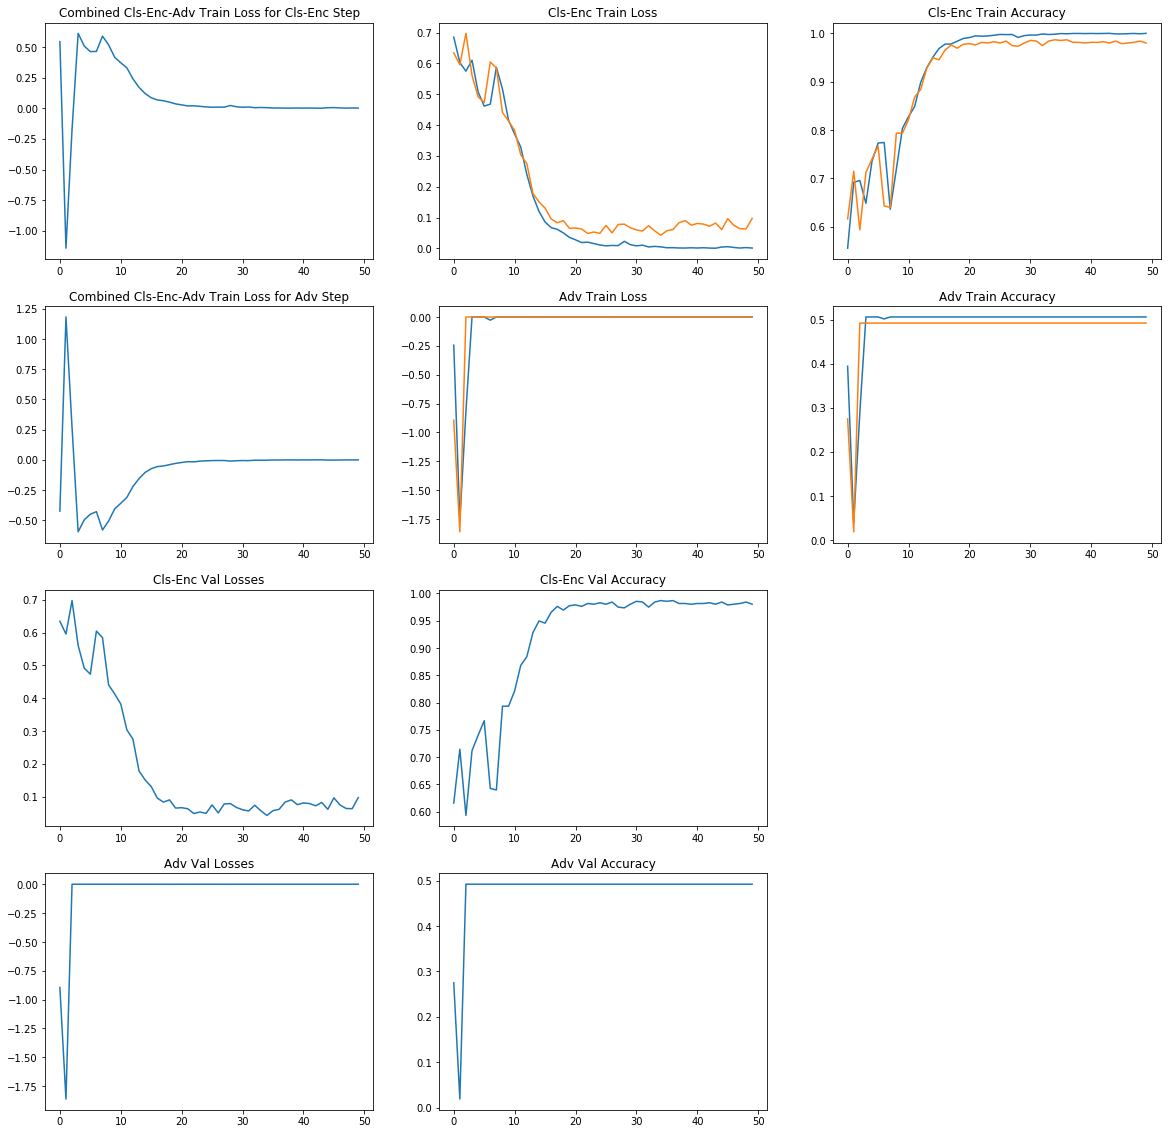

In [28]:
plt.figure(figsize=(20,20))
plt.subplot(431)
plt.title('Combined Cls-Enc-Adv Train Loss for Cls-Enc Step')
plt.plot(clsTrainCombined_losses)

plt.subplot(432)
plt.title('Cls-Enc Train Loss')
plt.plot(clsTrain_losses)
plt.plot(clsVal_losses)

plt.subplot(433)
plt.title('Cls-Enc Train Accuracy')
plt.plot(clsTrain_accs)
plt.plot(clsVal_accs)
plt.subplot(434)
plt.title('Combined Cls-Enc-Adv Train Loss for Adv Step')
plt.plot(advTrainCombined_losses)
plt.subplot(435)
plt.title('Adv Train Loss')
plt.plot(advTrain_losses)
plt.plot(advVal_losses)

plt.subplot(436)
plt.title('Adv Train Accuracy')
plt.plot(advTrain_accs)
plt.plot(advVal_accs)

plt.subplot(437)
plt.title('Cls-Enc Val Losses')
plt.plot(clsVal_losses)
plt.subplot(438)
plt.title('Cls-Enc Val Accuracy')
plt.plot(clsVal_accs)
plt.subplot(4,3,10)
plt.title('Adv Val Losses')
plt.plot(advVal_losses)
plt.subplot(4,3,11)
plt.title('Adv Val Accuracy')
plt.plot(advVal_accs)

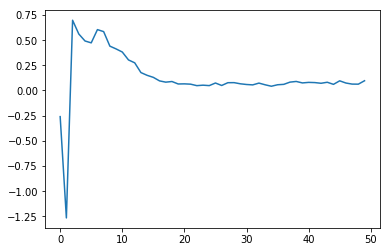

In [29]:
plt.plot(combinedVal_losses)

In [ ]:
with open('plot_data/eo/laftr_p2_100.pkl', 'wb') as f:
    pickle.dump([clsTrain_accs, clsTrainCombined_losses, 
                 clsTrain_losses, advTrain_losses, 
                 advTrain_accs, advTrainCombined_losses,
                 combinedVal_losses, clsVal_losses,
                 clsVal_accs, advVal_losses, advVal_accs], f)